In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-original/mnist-original.mat


In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [3]:
mnist = loadmat("/kaggle/input/mnist-original/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

In [4]:
print(mnist_data.shape)
print(mnist_label.shape)

(70000, 784)
(70000,)


In [5]:
x = mnist_data
y = mnist_label

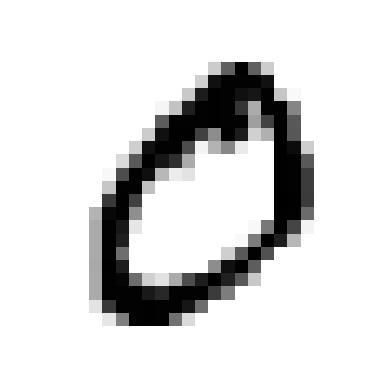

In [6]:
some_digit = mnist_data[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [7]:
mnist_label[0]

0.0

In [8]:
mnist_label = mnist_label.astype(np.uint8)
type(mnist_label[0])

numpy.uint8

In [9]:
xtrain, xtest, ytrain, ytest = x[:60000], x[60000:], y[:60000], y[60000:]

**Training a binary classifier**

In [10]:
ytrain5 = (ytrain == 5)
ytest5 = (ytest == 5)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(xtrain, ytrain5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([False])

**Accuracy**

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, xtrain, ytrain5, cv = 3, scoring = "accuracy")

array([0.89345, 0.75235, 0.7899 ])

**Confusion matrix**

First, we would require some predictions. Hence, using cross_val_predict to get prediction.

In [14]:
from sklearn.model_selection import cross_val_predict 

y_train5_pred = cross_val_predict(sgd_clf, xtrain, ytrain5, cv = 3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytrain5, y_train5_pred)

array([[44363, 10216],
       [ 1070,  4351]])

In [16]:
from sklearn.metrics import precision_score, recall_score

print("Precision score: ", precision_score(ytrain5, y_train5_pred))
print("Recall score: ",recall_score(ytrain5, y_train5_pred))

Precision score:  0.298688817189538
Recall score:  0.8026194429072127


Precision and recall have a trade-off, meaning at a time, only one of them will have a high value. If you have a high precision, recall would be low. Vice-versa, having high recall would imply having low precision. 

In [17]:
from sklearn.metrics import f1_score

f1_score(ytrain5, y_train5_pred)

0.43536121673003797

f1_score favours classifiers that have both the precision and recall values high. 

SGDclassifier makes its decision on a score based on decision function. If that score is greater than the threshold , it assigns the instance to positive class, else it is assigned to negative class. Be default the threshold for SGDClassifier is 0. 

In [18]:
yscores = sgd_clf.decision_function([some_digit])
print(yscores)

[-12176.16696692]


In [19]:
threshold = 0 
y_some_digit_pred = (yscores > threshold)
y_some_digit_pred

array([False])

Now, this is absolutely correct as the digit is 0, not 5. Trying to change the threshold and let us see the changes.

In [20]:
threshold = -15000
y_some_digit_pred = (yscores > threshold)
y_some_digit_pred

array([ True])

Plotting precision-recall curve to get the appropriate value of decision threshold.

In [21]:
yscores = cross_val_predict(sgd_clf, xtrain, ytrain5, cv = 3, method = "decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(ytrain5,yscores)

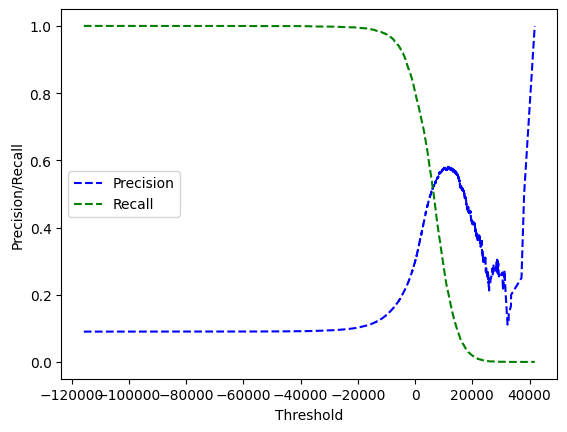

In [23]:
plt.plot(threshold, precision[:-1], "b--", label = "Precision")
plt.plot(threshold, recall[:-1], "g--", label = "Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend()

Text(0, 0.5, 'Precision')

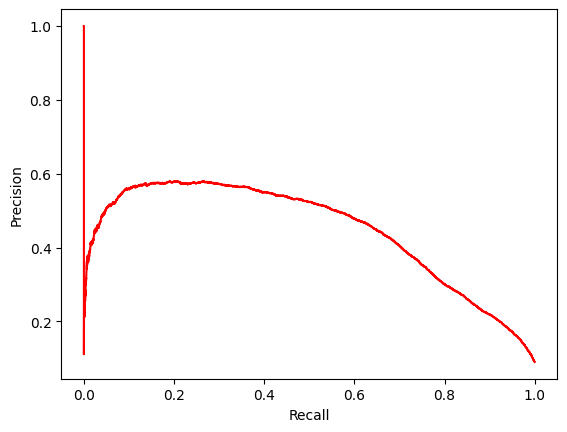

In [24]:
plt.plot(recall, precision, "r")
plt.xlabel("Recall")
plt.ylabel("Precision")

**Receiver Operating Curve(ROC)**

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(ytrain5, yscores)

Text(0.5, 1.0, 'ROC Curve - SGD Classifier')

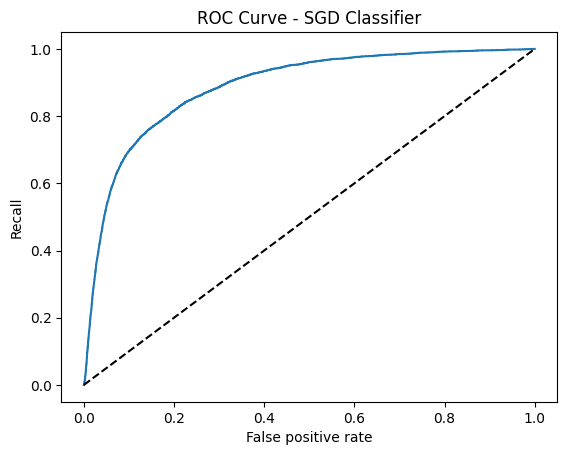

In [48]:
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False positive rate")
plt.ylabel("Recall")
plt.title("ROC Curve - SGD Classifier")

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ytrain5, yscores)

0.8873322501447319

After working with SGD Classifier, let us try Random Forest Classifier as well

In [41]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(random_state = 42)

In [44]:
y_probas = cross_val_predict(random_forest_clf, xtrain, ytrain5, cv = 3, method = "predict_proba")

In [45]:
print(y_probas)

[[0.74 0.26]
 [0.68 0.32]
 [0.92 0.08]
 ...
 [0.87 0.13]
 [0.85 0.15]
 [0.89 0.11]]


In [47]:
yscoresforest = y_probas[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(ytrain5, yscoresforest)

Text(0.5, 1.0, 'ROC Curve - Random Forest Classifier')

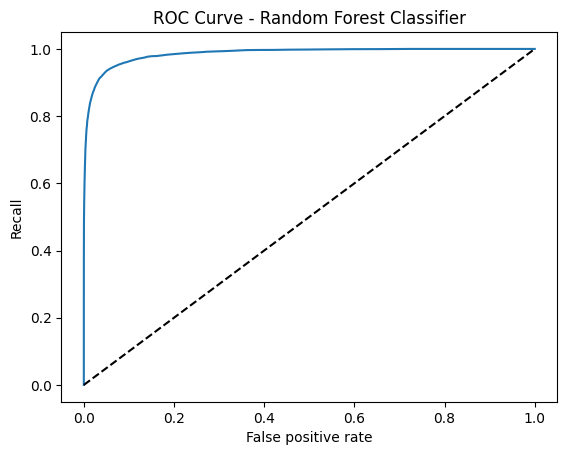

In [49]:
plt.plot(fpr_forest, tpr_forest)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False positive rate")
plt.ylabel("Recall")
plt.title("ROC Curve - Random Forest Classifier")

In [50]:
roc_auc_score(ytrain5, yscoresforest)

0.9859689313269965

**As can be seen, RandomForestClassifier performs exceptionaly well then SGDClassifier**

**Multiclass Classification**

In [51]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(xtrain, ytrain)
svm_clf.predict([some_digit])

array([0.])

In [52]:
somedigitscores = svm_clf.decision_function([some_digit])
somedigitscores

array([[ 9.31776763,  0.69966542,  8.26937495,  3.82063539, -0.30671293,
         7.27141643,  3.80978873,  1.72165536,  6.0316466 ,  3.83885601]])

As can be seen, decision_function is returning 10 values, so the classifier uses OvO strategy. We can change the strategy to OvR as well. 

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(SVC())
clf.fit(xtrain, ytrain)
clf.predict([some_digit])